In [1]:
import numpy as np
import pytensor.tensor as pt

import pymc as pm

In [2]:
with pm.Model() as m:
    X = pm.Normal("X", 0, 1, size=(100, 10))
    alpha = pm.Normal("alpha", 100, 10)
    beta = pm.Normal("beta", 0, 5, size=(10,))

    mu = alpha + X @ beta
    sigma = pm.Exponential("sigma", 1)
    y = pm.Normal("y", mu=mu, sigma=sigma)

    prior = pm.sample_prior_predictive()

Sampling: [X, alpha, beta, sigma, y]


In [3]:
draw = 123
true_params = np.r_[
    prior.prior.alpha.sel(chain=0, draw=draw).values,
    prior.prior.beta.sel(chain=0, draw=draw),
    prior.prior.sigma.sel(chain=0, draw=draw),
]
X_data = prior.prior.X.sel(chain=0, draw=draw).values
y_data = prior.prior.y.sel(chain=0, draw=draw).values

In [4]:
m_obs = pm.observe(pm.do(m, {X: X_data}), {"y": y_data})

In [5]:
Parameter = pt.tensor

draws = pt.tensor("draws", shape=(), dtype="int64")

with pm.Model() as guide_model:
    X = pm.Data("X", X_data)
    alpha_loc = Parameter("alpha_loc", shape=())
    alpha_scale = Parameter("alpha_scale", shape=())
    alpha_z = pm.Normal("alpha_z", mu=0, sigma=1, shape=(draws,))
    alpha = pm.Deterministic("alpha", alpha_loc + alpha_scale * alpha_z)

    beta_loc = Parameter("beta_loc", shape=(10,))
    beta_scale = Parameter("beta_scale", shape=(10,))
    beta_z = pm.Normal("beta_z", mu=0, sigma=1, shape=(draws, 10))
    beta = pm.Deterministic("beta", beta_loc + beta_scale * beta_z)

    mu = alpha + X @ beta

    sigma_loc = Parameter("sigma_loc", shape=())
    sigma_scale = Parameter("sigma_scale", shape=())
    sigma_z = pm.Normal("sigma_z", 0, 1, shape=(draws,))
    sigma = pm.Deterministic("sigma", pt.softplus(sigma_loc + sigma_scale * sigma_z))

# with pm.Model() as guide_model2:
#     n = 10 + 1 + 1
#     loc = Parameter("loc", shape=(n,))
#     chol_flat = Parameter("chol", shape=(n * n-1, ))
#     chol = pm.expand_packed_triangular(n, chol_flat)
#     latent_mvn = pm.MvNormal("latent_mvn", chol=chol)

#     pm.Deterministic("beta", latent_mvn[:10])
#     pm.Deterministic("alpha", latent_mvn[10])
#     pm.Deterministic("sigma", pm.math.exp(latent_mvn[11]))

In [6]:
params = [alpha_loc, alpha_scale, beta_loc, beta_scale, sigma_loc, sigma_scale]

In [22]:
import pytensor

In [30]:
from pymc.variational.autoguide import AutoDiagonalNormal

generated_guide_model = AutoDiagonalNormal(m_obs)
generated_guide_logp = generated_guide_model.logp()

ggdraws, *ggparams = list(
    pytensor.graph.traversal.explicit_graph_inputs(generated_guide_model.deterministics)
)
ggdraws, ggparams

/home/z/upstream/pymc/pymc/model/core.py:1409: UserWarning: To disable default transform, please use default_transform=None instead of transform=None. Setting transform to None will not have any effect in future.
  warnings.warn(
/home/z/upstream/pymc/pymc/model/core.py:1409: UserWarning: To disable default transform, please use default_transform=None instead of transform=None. Setting transform to None will not have any effect in future.
  warnings.warn(


(draws, [alpha_scale, alpha_loc, beta_scale, beta_loc, sigma_scale, sigma_loc])

In [28]:
from pytensor.graph.replace import graph_replace, vectorize_graph

outputs = [m_obs.datalogp, m_obs.varlogp]
inputs = m_obs.value_vars
inputs_to_guide_rvs = {
    model_value_var: guide_model[rv.name]
    for rv, model_value_var in m_obs.rvs_to_values.items()
    if rv not in m_obs.observed_RVs
}
model_logp = vectorize_graph(m_obs.logp(), inputs_to_guide_rvs)
guide_logq = graph_replace(guide_model.logp(), guide_model.values_to_rvs)

negative_elbo = (guide_logq - model_logp).mean()
d_loss = pt.grad(negative_elbo, params)

f_loss_dloss = pm.compile([draws, *params], [negative_elbo, *d_loss], trust_input=True)

In [14]:
init_dict = m_obs.initial_point()
init_dict = {k: np.expand_dims(v, 0) for k, v in init_dict.items()}
param_dict = {param.name: np.full(param.type.shape, 0.5) for param in params}

In [34]:
from tqdm import trange

learning_rate = 1e-5
n_iter = 60_000
loss_history = np.empty(n_iter)
progress_bar = trange(n_iter)
for i in progress_bar:
    loss, *grads = f_loss_dloss(**param_dict, draws=500)
    loss_history[i] = loss
    for (name, value), grad in zip(param_dict.items(), grads):
        param_dict[name] = (value - learning_rate * grad).copy()
    if i % 50 == 0:
        progress_bar.set_description(f"Loss: {loss:.2f}")
    if i % 10_000 == 0 and i > 0:
        learning_rate = min(learning_rate * 10, 1e-3)

Loss: -8269.45: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [01:04<00:00, 923.85it/s]


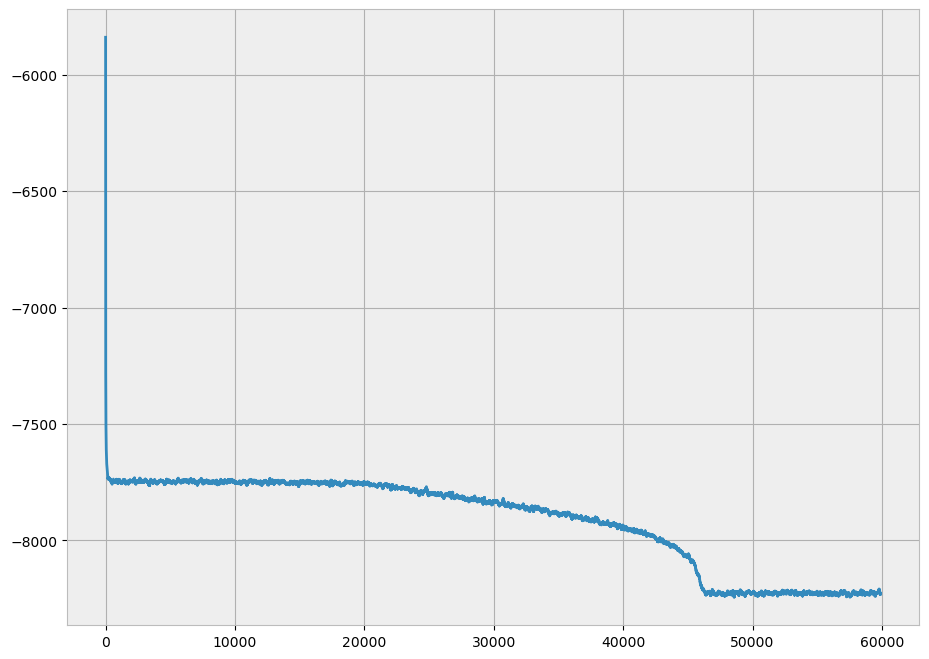

In [16]:
import matplotlib.pyplot as plt

window_size = 100
kernel = np.full(window_size, 1 / window_size)
plt.plot(np.convolve(loss_history, kernel, mode="valid"))

In [17]:
np.r_[param_dict["alpha_loc"], param_dict["beta_loc"], param_dict["sigma_loc"]]

array([100.60816032,   1.96557729,   7.73955076,  -7.66457174,
         2.53516612,  -5.41900137,  -0.99477267,   4.01480935,
         3.08898867,  -3.56437801,   4.88723671,   0.67686201])

In [18]:
true_params

array([100.32521589,   2.32960583,   7.81388676,  -7.89054847,
         2.6604157 ,  -5.59012429,  -1.35834213,   3.93360118,
         2.63242305,  -4.30102687,   4.33576601,   2.94219011])

## Todo:

- Does this "two models" frameworks fits into what we already have?
- `model_to_mean_field` transformation
- rsample --> stochastic gradients? Or automatic reparameterization?
- figure out guide param initalization
- More flexible optimizers...